<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-8/ERA1_S8_Normalization_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Normalization and Regularization Effects
### Different trials to study effects of normalization and regularization on CNN model using MNIST dataset 

- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN

## Plotting the loss functions overlayed
## Plotting the misclassification images



## Loading model file

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model8 import *

## Data Transformations


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [6]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 111326337.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80275476.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25708582.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16035798.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalizationMethod='GN').to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Training and Testing

In [9]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, runName, L1flag=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    # L1 Regularization
    if L1flag:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    train_losses[runName].append(loss.item())
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[runName].append(100*correct/processed)

def test(model, device, test_loader, runName):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[runName].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[runName].append(100. * correct / len(test_loader.dataset))

## Network with Group Normalization

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net(normalizationMethod='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='GN')
    scheduler.step()
    test(model, device, test_loader, runName='GN')

EPOCH: 0


Loss=0.1525232344865799 Batch_id=468 Accuracy=90.13: 100%|██████████| 469/469 [00:34<00:00, 13.61it/s]



Test set: Average loss: 0.0736, Accuracy: 9771/10000 (97.71%)

EPOCH: 1


Loss=0.06746373325586319 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]



Test set: Average loss: 0.0434, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.10679328441619873 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0445, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.029468027874827385 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]



Test set: Average loss: 0.0338, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.009840072132647038 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]



Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.06184111908078194 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]



Test set: Average loss: 0.0334, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.03354949876666069 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.018665514886379242 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.022108882665634155 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.041678737848997116 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]



Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.01146482303738594 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:27<00:00, 17.00it/s]



Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.043073251843452454 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.020629271864891052 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.010404394008219242 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.007680485490709543 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]



Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.008690849877893925 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]



Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.03737999126315117 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]



Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.033381495624780655 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.010096143931150436 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.013029612600803375 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.019975533708930016 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.026204844936728477 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.03415730968117714 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.00941187608987093 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.003641365794464946 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)



In [11]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to plot misclassified images
def plot_misclassified_images(model, test_loader):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


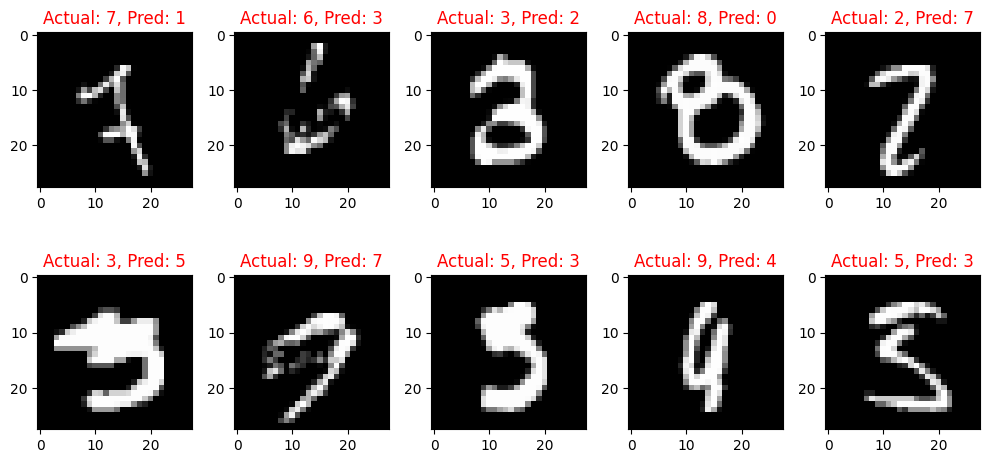

In [12]:
plot_misclassified_images(model, test_loader)

## Network with Layer Normalization

In [13]:
model =  Net(normalizationMethod='LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='LN')
    scheduler.step()
    test(model, device, test_loader, runName='LN')

EPOCH: 0


Loss=0.07399492710828781 Batch_id=468 Accuracy=89.56: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]



Test set: Average loss: 0.0793, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.05929587408900261 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]



Test set: Average loss: 0.0431, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.04790486395359039 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]



Test set: Average loss: 0.0477, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.11237496882677078 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.0345, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.09399338811635971 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]



Test set: Average loss: 0.0369, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.004545200150460005 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]



Test set: Average loss: 0.0310, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.0538380891084671 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.0512087307870388 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]



Test set: Average loss: 0.0245, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.02068532444536686 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]



Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.05021150782704353 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.10982344299554825 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]



Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.14013083279132843 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]



Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.021055830642580986 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]



Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.014738090336322784 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.05149974301457405 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.050836700946092606 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.03922379016876221 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.015070933848619461 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]



Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.035861920565366745 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.005712642800062895 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.05794547498226166 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.021249989047646523 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.022153625264763832 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.0028858494479209185 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Loss=0.019949059933423996 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)



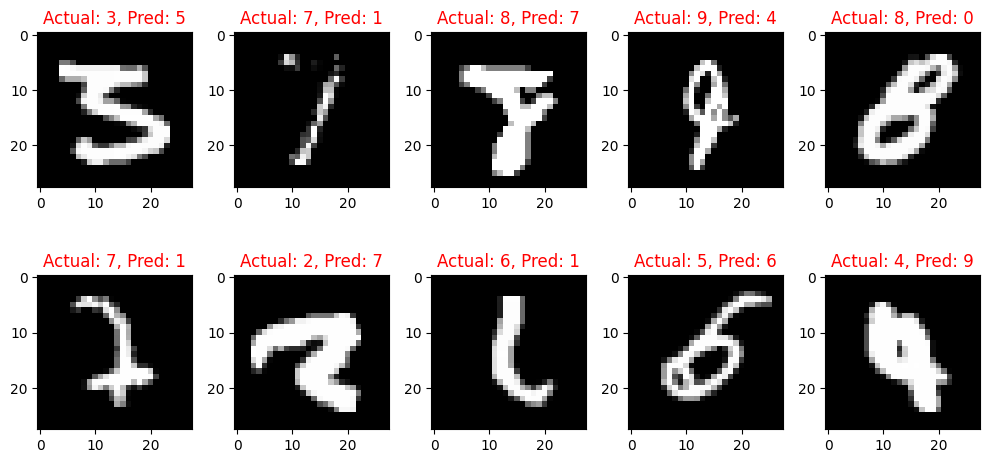

In [14]:
plot_misclassified_images(model, test_loader)

## Network with L1 + BN

In [15]:
model =  Net(normalizationMethod='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='BN',  L1flag=True)
    scheduler.step()
    test(model, device, test_loader, runName='BN')

EPOCH: 0


Loss=0.08112204819917679 Batch_id=468 Accuracy=92.06: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]



Test set: Average loss: 0.0493, Accuracy: 9855/10000 (98.55%)

EPOCH: 1


Loss=0.09060082584619522 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]



Test set: Average loss: 0.0354, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.0774683803319931 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s]



Test set: Average loss: 0.0338, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.18598055839538574 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]



Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.08385970443487167 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]



Test set: Average loss: 0.0270, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.09647310525178909 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]



Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.05404539406299591 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]



Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.024878384545445442 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]



Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.0400409959256649 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s]



Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.056392934173345566 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 17.37it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.01919112727046013 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.019142024219036102 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]



Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.010383009910583496 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]



Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.03752800449728966 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.011697333306074142 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.03422754630446434 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.02821115404367447 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.015013430267572403 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.015283221378922462 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]



Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.02559192292392254 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.04365525394678116 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:27<00:00, 17.24it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 21


Loss=0.019817069172859192 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]



Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.02621614560484886 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]



Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.03359677642583847 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]



Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.017277611419558525 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]



Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)



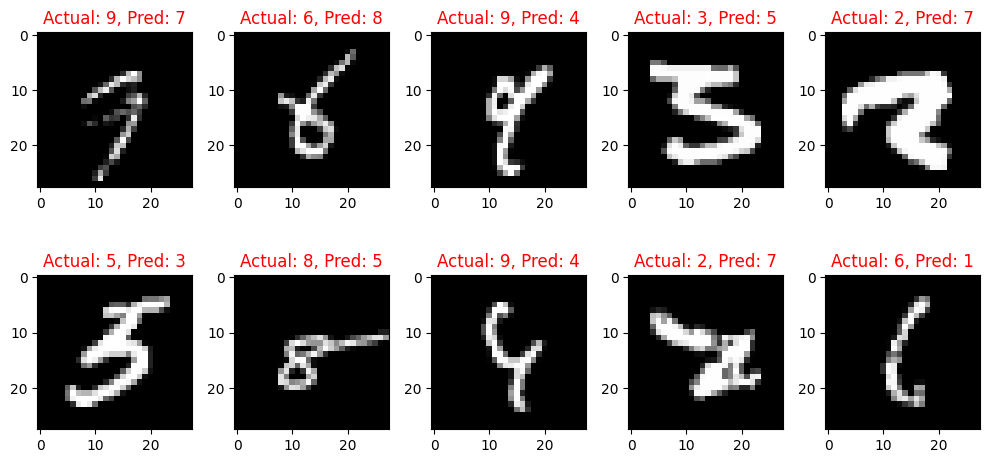

In [16]:
plot_misclassified_images(model, test_loader)

<ipython-input-17-5539caef9061>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


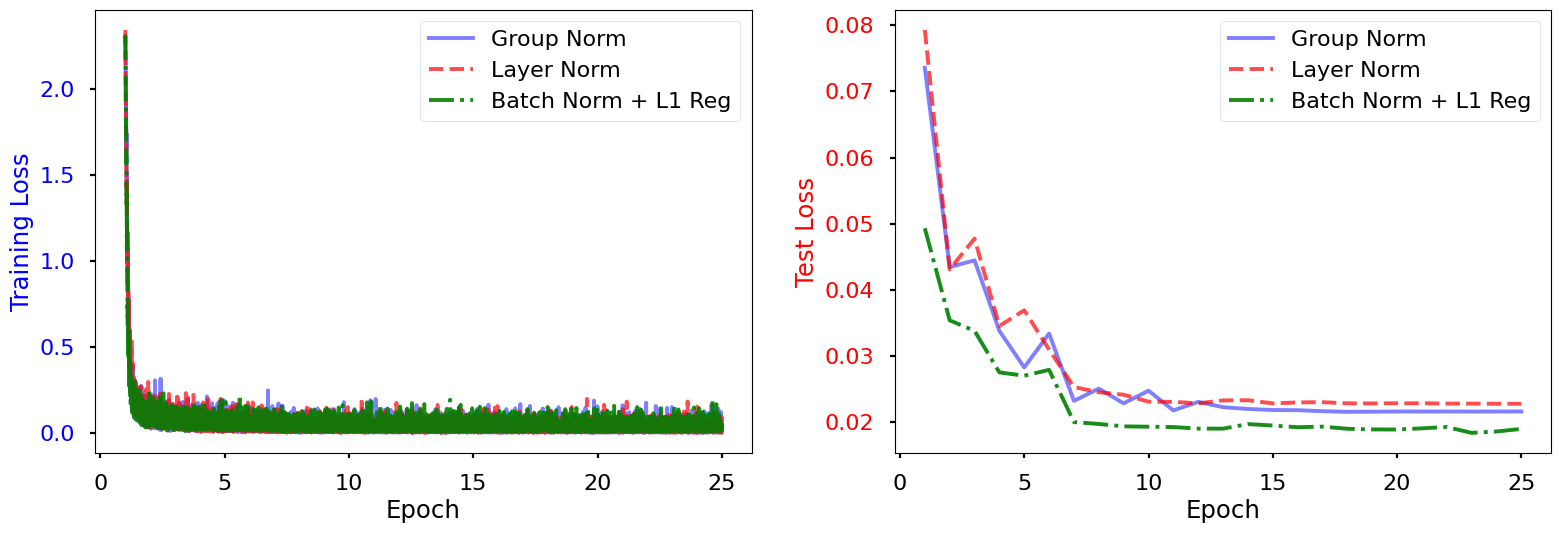

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'blue'
color2 = 'red'
color3 = 'green'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_losses['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_losses['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss', color=color1)
ax[0].plot(train_epoch_linspace, train_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='upper right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Loss', color=color2)
ax[1].plot(test_epoch_linspace, test_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='upper right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()

<ipython-input-18-d54eb478b391>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


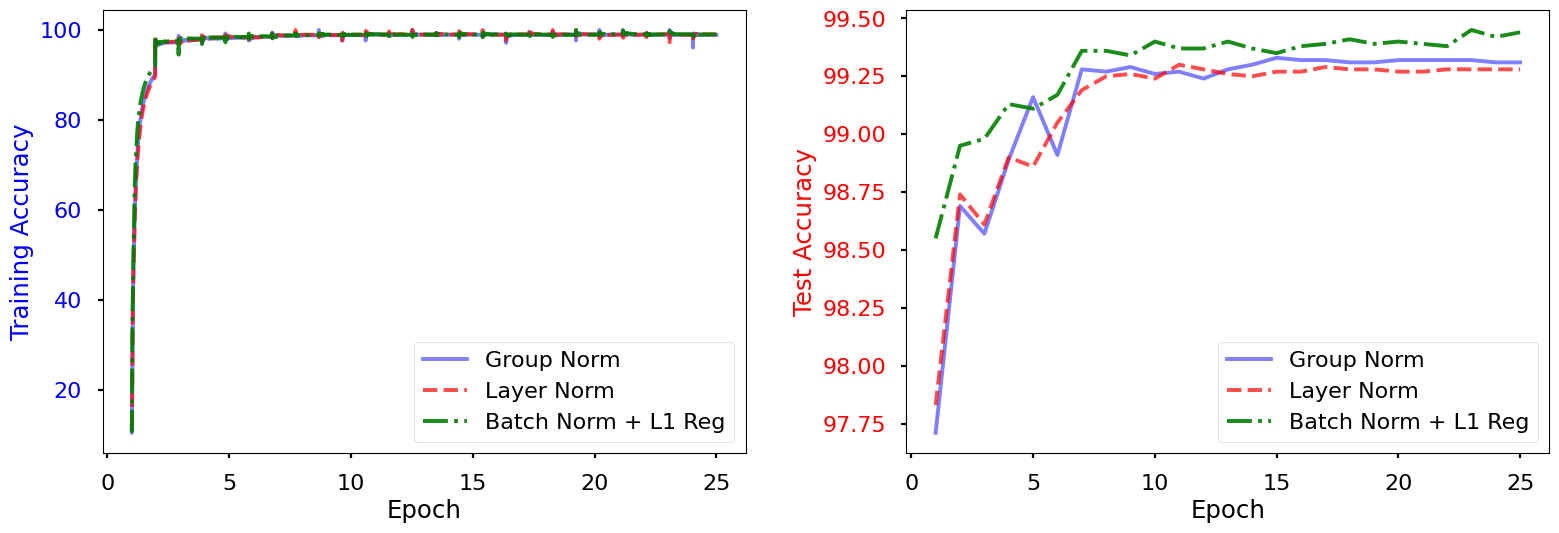

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')

fig, ax = plt.subplots(1, 2)

color1 = 'blue'
color2 = 'red'
color3 = 'green'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_acc['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_acc['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Accuracy', color=color1)
ax[0].plot(train_epoch_linspace, train_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='lower right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Accuracy', color=color2)
ax[1].plot(test_epoch_linspace, test_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='lower right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()